In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [2]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [3]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [19]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, file_name='scaling.png'):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    plt.xticks(scaling[x_axis])
    ax1.legend()
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)

    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [6]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'][2:], scaling['node_h'][2:], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [9]:
scaling = build_dataframe(x_axis='mpi', factor=160)
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  \
4  160     8     1280     40         1        1        5580.0   
2  320     8     2560     80         1        1        3600.0   
3  480     8     3840    120         1        1        2918.0   
1  640     8     5120    160         1        1        2402.0   
5  800     8     6400    200         1        1        2385.0   
0  960     8     7680    240         1        1        2292.0   

   io_ATMPROJ_pwscf  io_KB_abinit   io_BS  ...  Xo (REDUX)   Dipoles      Xo  \
4            0.0001        0.0001  0.0001  ...   1382.0000   89.0333  5160.0   
2            0.0002        0.0001  0.0242  ...   1078.0000  164.7118  3082.0   
3            0.0001        0.0001  0.0010  ...    848.0000  173.5209  2274.0   
1            0.0001        0.0001  0.0003  ...    668.0000  166.5171  1831.0   
5            0.0001        0.0001  0.0005  ...    531.8133  167.8196  1713.0   
0            0.0001        0.0079  0.0078  ...    558.3595  191.4032  1582.0   

   gpu  ideal   speedup  efficiency  Self energy     Other      node_h  
4  160    1.0  1.000000  100.000000     117.4845  187.5211   62.000000  
2  320    2.0  1.550000   77.500000      80.5550  251.5367   80.000000  
3  480    3.0  1.912269   63.742289      70.2141  378.0201   97.266667  
1  640    4.0  2.323064   58.076603      62.2575  319.9491  106.755556  
5  800    5.0  2.339623   46.792453      61.9640  419.6687  132.500000  
0  960    6.0  2.434555   40.575916      61.7565  433.8952  152.800000  

[6 rows x 53 columns]

In [10]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile   Dipoles      Xo        X  Self energy     Other
4  160        5580.0   89.0333  5160.0  25.9611     117.4845  187.5211
2  320        3600.0  164.7118  3082.0  21.1965      80.5550  251.5367
3  480        2918.0  173.5209  2274.0  22.2449      70.2141  378.0201
1  640        2402.0  166.5171  1831.0  22.2763      62.2575  319.9491
5  800        2385.0  167.8196  1713.0  22.5477      61.9640  419.6687
0  960        2292.0  191.4032  1582.0  22.9451      61.7565  433.8952

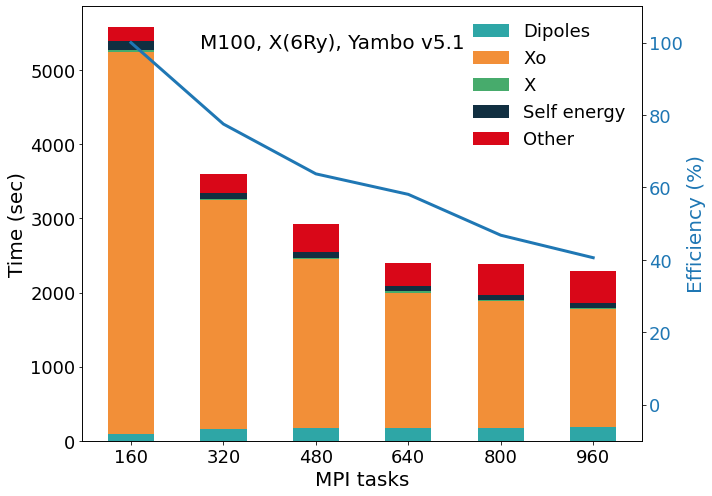

In [22]:
build_scaling_plot(scaling=scaling, pile=pile, colors=colors, bar_width=80, efficiency=True,
                   legend_loc='upper right', label=r'M100, X(6Ry), Yambo v5.1', label_pos=(280, 5300))

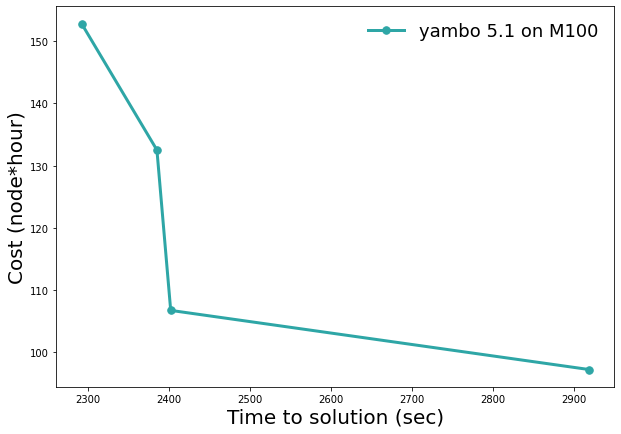

In [24]:
build_cost_plot(scaling=scaling, label='yambo 5.1 on M100', y_lim=None)